In [1]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta


# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Risk_Management')))

# Import the modules
from data import Data
from calculations import Calculations
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit

                                close  creturns      high  log_return  \
date                coin                                                
2020-12-31 19:00:00 BTCUSDT  29331.69       NaN  29600.00         NaN   
                    ETHUSDT    728.91       NaN    749.00         NaN   
2021-01-01 19:00:00 BTCUSDT  32178.33  1.097050  33300.00    0.092625   
                    ETHUSDT    774.56  1.062628    787.69    0.060745   
2021-01-02 19:00:00 BTCUSDT  33000.05  1.125065  34778.11    0.025216   
                    ETHUSDT    978.28  1.342114   1011.07    0.233501   
2021-01-03 19:00:00 BTCUSDT  31988.71  1.090585  33600.00   -0.031126   
                    ETHUSDT   1041.43  1.428750   1162.97    0.062554   
2021-01-04 19:00:00 BTCUSDT  33949.53  1.157435  34360.00    0.059492   
                    ETHUSDT   1099.56  1.508499   1134.60    0.054315   
2021-01-05 19:00:00 BTCUSDT  36769.36  1.253571  36939.21    0.079790   
                    ETHUSDT   1208.42  1.657845   1

In [2]:
symbols = ['BTCUSDT', 'ETHUSDT']
start_time = dt.datetime(2024, 1, 1)
end_time = dt.datetime(2024, 2, 1)
timeframe = '1h'
data = Data(symbols, timeframe, start_time, end_time).df
#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(data, 1000)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, 2, 2)
fine = Fine()
df = fine.above_ema(df, 2)
#Generate a signal
tf = Trend_Following()
mr = Mean_Reversion()
str_length = 10
str_mult = 3
_df = tf.supertrend_signals(df, str_length, str_mult)
condition = _df[f'SUPERTd_{str_length}_{float(str_mult)}'] == 1
_df['position'] = np.where(condition, 1, 0)
_df['position'] = _df['position'].shift(len(_df.index.get_level_values(1).unique())).fillna(0)
_df = Calculations().trades(_df)
_df = Calculations().strategy_returns(_df)
_df = Calculations().sessions(_df)
_df

close  creturns      high  log_return  \
date                                                                    
2023-12-31 19:00:00 BTCUSDT  42475.23       NaN  42554.57         NaN   
                    ETHUSDT   2295.51       NaN   2297.18         NaN   
2023-12-31 20:00:00 BTCUSDT  42613.56  1.003257  42775.00    0.003251   
                    ETHUSDT   2303.72  1.003577   2306.60    0.003570   
2023-12-31 21:00:00 BTCUSDT  42581.10  1.002493  42638.41   -0.000762   
...                               ...       ...       ...         ...   
2024-01-31 16:00:00 ETHUSDT   2279.00  0.992808   2292.37   -0.003933   
2024-01-31 17:00:00 BTCUSDT  42656.07  1.004258  42690.42    0.003969   
                    ETHUSDT   2285.75  0.995748   2287.94    0.002957   
2024-01-31 18:00:00 BTCUSDT  42580.00  1.002467  42688.88   -0.001785   
                    ETHUSDT   2283.14  0.994611   2288.91   -0.001143   

                                  low      open   returns       volume  \
date                                                                     
2023-12-31 19:00:00 BTCUSDT  42261.02  42283.58       NaN   1271.68108   
                    ETHUSDT   2281.27   2281.87       NaN  10771.91830   
2023-12-31 20:00:00 BTCUSDT  42431.65  42475.23  0.003257   1196.37856   
                    ETHUSDT   2292.90   2295.52  0.003577   8413.42600   
2023-12-31 21:00:00 BTCUSDT  42500.00  42613.57 -0.000762    685.21980   
...                               ...       ...       ...          ...   
2024-01-31 16:00:00 ETHUSDT   2263.57   2287.98 -0.003925  23011.28190   
2024-01-31 17:00:00 BTCUSDT  42381.10  42487.12  0.003976   1398.31850   
                    ETHUSDT   2269.03   2278.99  0.002962  10362.16650   
2024-01-31 18:00:00 BTCUSDT  42555.46  42656.07 -0.001783   1257.92790   
                    ETHUSDT   2281.88   2285.75 -0.001142   9636.50420   

                             volume_in_dollars  volume_flag  ...  \
date                                                         ...   
2023-12-31 19:00:00 BTCUSDT       5.401495e+07            1  ...   
                    ETHUSDT       2.472705e+07            1  ...   
2023-12-31 20:00:00 BTCUSDT       5.098195e+07            1  ...   
                    ETHUSDT       1.938218e+07            1  ...   
2023-12-31 21:00:00 BTCUSDT       2.917741e+07            1  ...   
...                                        ...          ...  ...   
2024-01-31 16:00:00 ETHUSDT       5.244271e+07            1  ...   
2024-01-31 17:00:00 BTCUSDT       5.964677e+07            1  ...   
                    ETHUSDT       2.368532e+07            1  ...   
2024-01-31 18:00:00 BTCUSDT       5.356257e+07            1  ...   
                    ETHUSDT       2.200149e+07            1  ...   

                             SUPERT_10_3.0  SUPERTd_10_3.0  SUPERTl_10_3.0  \
date                                                                         
2023-12-31 19:00:00 BTCUSDT       0.000000               1             NaN   
                    ETHUSDT       0.000000               1             NaN   
2023-12-31 20:00:00 BTCUSDT            NaN               1             NaN   
                    ETHUSDT            NaN               1             NaN   
2023-12-31 21:00:00 BTCUSDT            NaN               1             NaN   
...                                    ...             ...             ...   
2024-01-31 16:00:00 ETHUSDT    2346.264505              -1             NaN   
2024-01-31 17:00:00 BTCUSDT   43680.887427              -1             NaN   
                    ETHUSDT    2345.623055              -1             NaN   
2024-01-31 18:00:00 BTCUSDT   43680.887427              -1             NaN   
                    ETHUSDT    2345.623055              -1             NaN   

                             SUPERTs_10_3.0  position  trades  strategy  \
date                                                                      
2023-12-31 19:00:00 BTCUSDT             NaN       0.0     0.0       N

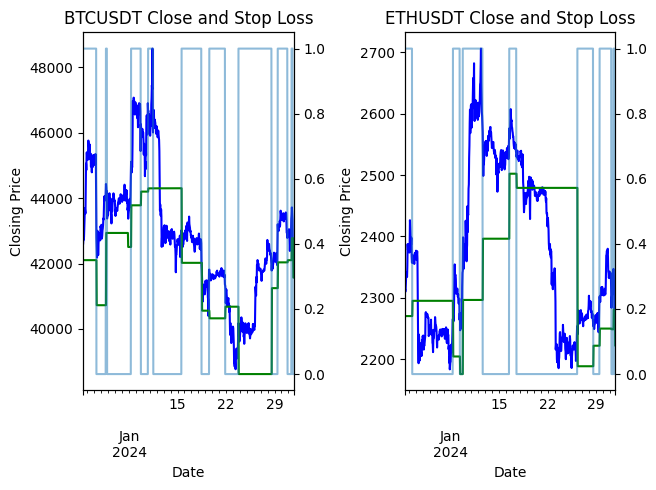

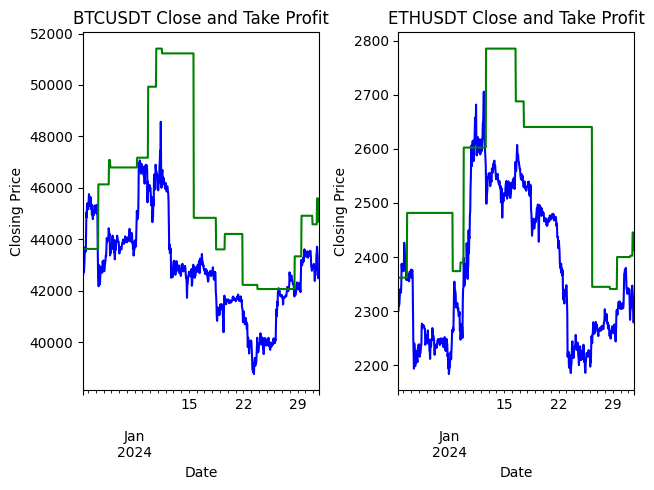

close  creturns      high  log_return  \
date                                                                    
2024-01-01 09:00:00 BTCUSDT  42612.24  1.003226  42715.55   -0.002421   
                    ETHUSDT   2300.99  1.002387   2305.11   -0.001377   
2024-01-01 10:00:00 BTCUSDT  42783.05  1.007247  42847.07    0.004000   
                    ETHUSDT   2314.70  1.008360   2318.34    0.005941   
2024-01-01 11:00:00 BTCUSDT  42725.15  1.005884  42856.00   -0.001354   
...                               ...       ...       ...         ...   
2024-01-31 16:00:00 ETHUSDT   2279.00  0.992808   2292.37   -0.003933   
2024-01-31 17:00:00 BTCUSDT  42656.07  1.004258  42690.42    0.003969   
                    ETHUSDT   2285.75  0.995748   2287.94    0.002957   
2024-01-31 18:00:00 BTCUSDT  42580.00  1.002467  42688.88   -0.001785   
                    ETHUSDT   2283.14  0.994611   2288.91   -0.001143   

                                  low      open   returns       volume  \
date                                                                     
2024-01-01 09:00:00 BTCUSDT  42580.00  42715.54 -0.002418    711.01152   
                    ETHUSDT   2294.84   2304.16 -0.001376   7316.25750   
2024-01-01 10:00:00 BTCUSDT  42586.51  42612.24  0.004008    942.70163   
                    ETHUSDT   2299.20   2300.99  0.005958  12303.53440   
2024-01-01 11:00:00 BTCUSDT  42664.42  42783.05 -0.001353    918.71056   
...                               ...       ...       ...          ...   
2024-01-31 16:00:00 ETHUSDT   2263.57   2287.98 -0.003925  23011.28190   
2024-01-31 17:00:00 BTCUSDT  42381.10  42487.12  0.003976   1398.31850   
                    ETHUSDT   2269.03   2278.99  0.002962  10362.16650   
2024-01-31 18:00:00 BTCUSDT  42555.46  42656.07 -0.001783   1257.92790   
                    ETHUSDT   2281.88   2285.75 -0.001142   9636.50420   

                             volume_in_dollars  volume_flag  ...  session  \
date                                                         ...            
2024-01-01 09:00:00 BTCUSDT       3.029779e+07            1  ...      0.0   
                    ETHUSDT       1.683464e+07            1  ...      0.0   
2024-01-01 10:00:00 BTCUSDT       4.033165e+07            1  ...      0.0   
                    ETHUSDT       2.847899e+07            1  ...      0.0   
2024-01-01 11:00:00 BTCUSDT       3.925205e+07            1  ...      0.0   
...                                        ...          ...  ...      ...   
2024-01-31 16:00:00 ETHUSDT       5.244271e+07            1  ...     12.0   
2024-01-31 17:00:00 BTCUSDT       5.964677e+07            1  ...     16.0   
                    ETHUSDT       2.368532e+07            1  ...     12.0   
2024-01-31 18:00:00 BTCUSDT       5.356257e+07            1  ...     16.0   
                    ETHUSDT       2.200149e+07            1  ...     12.0   

                             overall_session_return  session_compound  \
date                                                                    
2024-01-01 09:00:00 BTCUSDT                0.007190               0.0   
                    ETHUSDT                0.000124               0.0   
2024-01-01 10:00:00 BTCUSDT                0.007190               0.0   
                    ETHUSDT                0.000124               0.0   
2024-01-01 11:00:00 BTCUSDT                0.007190               0.0   
...                                             ...               ...   
2024-01-31 16:00:00 ETHUSDT                0.000000               0.0   
2024-01-31 17:00:00 BTCUSDT                0.000000               0.0   
                    ETHUSDT                0.000000               0.0   
2024-01-31 18:00:00 BTCUSDT                0.000000               0.0   
                    ETHUSDT                0.000000               0.0   

                                    atr     stop_loss  session_stop_loss  \
date                                                                       
2024-01-01 09:0

In [3]:
sl = Stop_Loss(_df, sl_type='atr', indicator_length=14, sl_mult=3)
_df = sl.apply_stop_loss(fixed = True, plot = True)
tp = Take_Profit(_df, 'rr', 2)
_df = tp.apply_take_profit(fixed = True, plot = True)
_df

---

## Rebalancing Allocation

To rebalance allocations of subportfolios (a subportfolio may be a ) 

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

# 1. Load historical data
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    return data

# 2. Define a sample trading strategy
def trading_strategy(data, short_window, long_window):
    data["SMA_Short"] = data["close"].rolling(window=short_window).mean()
    data["SMA_Long"] = data["close"].rolling(window=long_window).mean()
    data["Signal"] = np.where(data["SMA_Short"] > data["SMA_Long"], 1, -1)  # 1 for Buy, -1 for Sell
    data["Strategy_Return"] = data["Signal"].shift(1) * data["Return"]
    return data

# 3. Split data into in-sample and out-of-sample periods
def split_data(data, train_size, test_size, step_size):
    start = 0
    while start + train_size + test_size <= len(data):
        train = data.iloc[start:start + train_size]
        test = data.iloc[start + train_size:start + train_size + test_size]
        yield train, test
        start += step_size

# 4. Optimize parameters on in-sample data
def optimize_parameters(train_data, param_grid):
    best_params = None
    best_performance = -np.inf
    for params in ParameterGrid(param_grid):
        result = trading_strategy(train_data.copy(), **params)
        performance = result["strategy"].sum()
        if performance > best_performance:
            best_performance = performance
            best_params = params
    return best_params

# 5. Test optimized parameters on out-of-sample data
def test_strategy(test_data, best_params):
    result = trading_strategy(test_data.copy(), **best_params)
    return result["strategy"].sum()

# 6. Walk-forward optimization loop
def walk_forward_optimization(data, train_size, test_size, step_size, param_grid):
    results = []
    for train, test in split_data(data, train_size, test_size, step_size):
        # Optimize on training data
        best_params = optimize_parameters(train, param_grid)
        # Test on out-of-sample data
        performance = test_strategy(test, best_params)
        results.append(performance)
    return results

# Example Usage
if __name__ == "__main__":
    # Load data
    _df = df
    data["Return"] = data["Close"].pct_change()

    # Parameter grid for optimization
    param_grid = {"short_window": range(5, 21, 5), "long_window": range(20, 101, 20)}

    # Walk-forward optimization
    train_size = 250  # Number of training days
    test_size = 50    # Number of testing days
    step_size = 50    # Step size for walk forward
    results = walk_forward_optimization(data.dropna(), train_size, test_size, step_size, param_grid)

    # Aggregate and analyze results
    print(f"Average out-of-sample performance: {np.mean(results):.2f}")

KeyError: 'Close'